# AI and Birdsong

Estimates say that there are roughly 10,000 individual species of bird on our planet, making it no suprise that bird enthusiasts, as well as researchers, spend countless hours in nature observing and tracking birds. Recorded birdsong can be a particularly useful tool in achieving a full picture of avian ecology. However, field research yields tens of thousands of hours of audio, making data processing an arduous and humanly infeasible task. Prior to the development of machine learning tools for audio, analyses like these would require teams of specialists an expensive amount of processing hours.

Using machine learning can revolutionize this process. Several models have already been created for the specific task of bird species identification based on birdsong audio, such as BIRDNET, developed by biologist Christy Hand. The article, ([What Does Conservation Sound Like](https://www.allaboutbirds.org/news/what-does-conservation-sound-like)), discusses how useful this tool can be in the context of research on the Eastern Black Rail. These elusive swamp birds have a small population in a hard-to-reach habitat, and researchers can spend decades of their lives in field researchers focused on this specific species without ever catching a glimpse, making research on these birds nearly impossible.  Remote recordings are the best way to monitor their hard-to-track populations, to avoid other invasive observational methods. But, real time listening for each Eastern Black Rail would be difficult and expensive. BIRDNET, a birdsong identification model, has helped researchers identify the Black Rail's call and assess area's ecological health. BIRDNET and other models like it have helped researchers analyze their recordings and better understand fascinating and rare corners of science such as these.

Our model aims to join these researchers in creating and using machine learning as a tool for tracking/maintaining ecological health. It accomplishes this by addresing one question: how does a certain species location impact its call?

# Dataset and Data Cleaning

Our dataset is a collection of bird songs and related information from the Xeno Canto avian vocalization database ([link](https://www.kaggle.com/datasets/samhiatt/xenocanto-avian-vocalizations-canv-usa)). It contains individual observations of bird song audio recordings, the species of bird, location of recording, latitude and longitude coordinates, duration of the recording, and some further information. Within the dataset are 2730 recordings of bird songs across 91 distinct species of birds.

Our goal is to create a deep learning model that takes in both spectrogram images of bird song recordings as well as numerical coordinate data in order to predict the bird species. This requires a significant amount of data processing and cleaning. To start, we had to create the spectrogram images from the audio recordings present in the dataset. This was done using the Librosa python library, and the process was straightforward. The resulting spectrograms look like this:




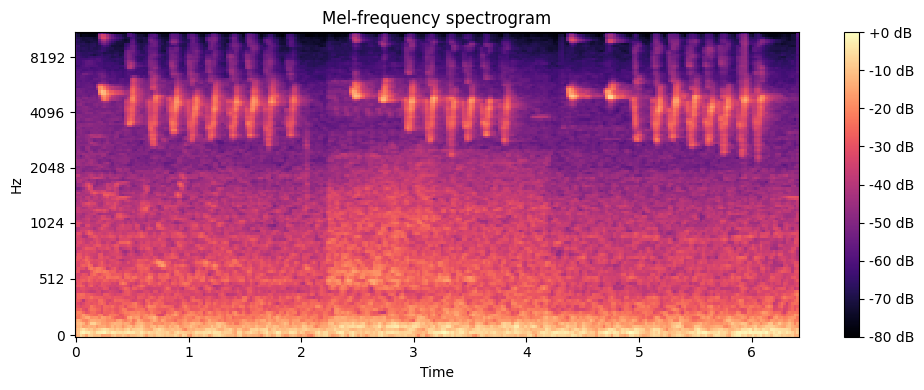

The issue is that each spectrogram takes five seconds to make, and at 2730 bird recordings, this would take almost four hours. So we began our training with a moderate sample of the data and only made spectrograms for that sample. Later on, we created the spectrograms for all 2730 observations, hosted them on google drive, and then loaded the pre-saved images into our model once we were further in the training process.

We chose not to resize the images before saving them to Google Drive, as this would allow us to determine the best image size after seeing how fast or slow our training is. This means that resizing the images is necessary each time they are loaded in. However, we see this added flexibility as an appropriate trade-off since resizing takes less than twenty seconds in total. At first, we resized all of the images to a common 224x224 pixels, but once we added in all 2730 images, the training became unmanageably slow. We resized down to 100x100 pixels to resolve this.

To simplify the data set we removed many columns unrelated to our analysis. It was consolidated to the index of the row, species of bird (common english name), file_id, latitude coordinate, and longitude coordinate. We titled each spectrogram image with its unique file_id from the original dataset so that this column could be used to tie each observation to its spectrogram. We also created a new column of label encodings, which contained a unique number to represent each bird species. Here are the first five rows: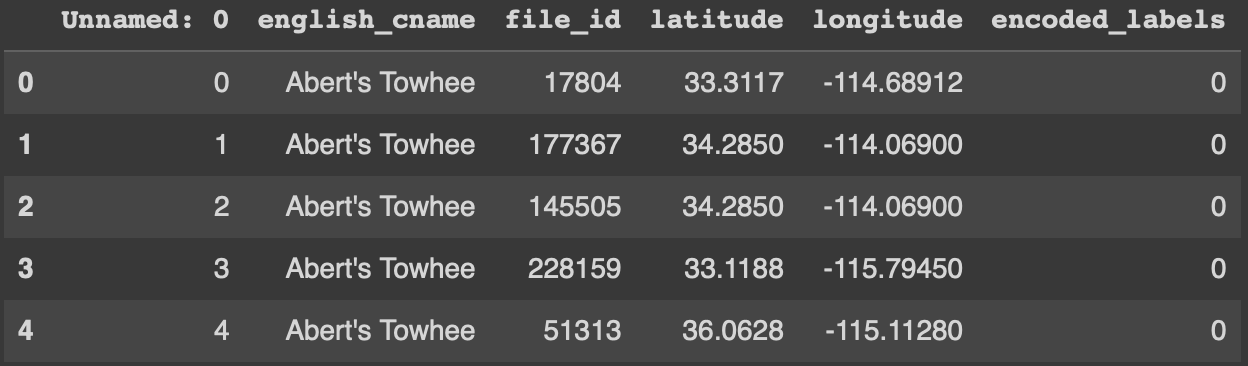

# Imports:

In [ ]:
!pip install pytorch-lightning

In [ ]:
from fastai.vision.all import *
from fastai.collab import *
from fastai.tabular.all import *
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.callback.schedule import fit_one_cycle
from fastai.metrics import accuracy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn.functional as F
from torchmetrics import Accuracy


import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.tuner import Tuner
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import LearningRateFinder


# Image Retrieval
We hosted both our spectrogram images as well as the consolidated dataset, saved as a pickle file, on google drive, which allowed us to quickly load them into Google Colab at any time without having to process anything. Both files are retrieved from Google Drive via the code below:


In [ ]:
# For this to work, you must have the zipfile with all images ("drizz_images_full.zip") and the pickle file with all tabular data ("drizz_tabs_full.pkl") saved in your "My Drive"

from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/drizz_images_full.zip" -d "/content/drizz_images.zip" # gets drizz_images.zip from google drive (first path), unzips it, and moves it into colab environment, keeping same name (2nd path)

!cp "/content/drive/My Drive/drizz_tabs_full.pkl" "/content/df.pkl" # gets a copy of the pickle and moves it into colab, naming it df.pkl

# Resizing

In [ ]:
from PIL import Image
import os

# Path to the images
image_folder = '/content/drizz_images.zip/content/processed_images/'

# Resize images
for filename in os.listdir(image_folder):
      img_path = os.path.join(image_folder, filename)
      with Image.open(img_path) as img:
          # Resize the image
          img_resized = img.resize((100, 100))
          # Save it back to overwrite the original image
          img_resized.save(img_path)

print("Image resizing complete.")

df = pd.read_pickle("df.pkl")

Image resizing complete.


# Our Model
The novel deep learning architecture that we set out to construct combines both images and numerical data for the purpose of label classification. There do not exist any pre-trained deep learning models that do this, so we accepted the challenge to create our own model. We adapted code from a [reference tutorial online](https://rosenfelder.ai/multi-input-neural-network-pytorch/) of a similar deep learning model which used images and tabular data to estimate real estate prices. The major distinction between the real estate neural network and our neural network is the nature of our tasks: theirs is regression, and ours is classification.

The main challenge of the model we made was figuring out how to effectively combine two distinct types of input data into the same model and then using both of them to make a prediction. The approach we adapted and refined was loading in both the image and coordinate data for each observation, converting them both into tensors, then sending them through their respective feature-extracting journeys. We implemented linear layers, convolutional blocks, ReLUs, batch normalization, max-pooling, and Dropout for this purpose. After the individualized feature extraction, the separate image and coordinate tensors are concatenated together, then put into one last linear layer which generates the model’s bird species prediction.

To convert this from a regression-based model to a classifier, we changed several things. We used our encoded labels column as the correct labels that we input into the model so that they were numerical. Accordingly, we changed our image data into long tensors, which are often used in the case of integers representing categories. Multiple input and output dimensions within our model had to be adjusted for the sake of classification, such as the final output size for the last linear layer, which had to be the number of unique bird species present in the model. Lastly, and perhaps most importantly, we had to adjust the loss function to Cross Entropy Loss so it worked with categorical predictions.

The source of our adapted code used PyTorch Lighting, a wrapper for PyTorch. Complications of PyTorch Lighting aside, the loss and accuracy results are presented in a series of “TensorBoardLogger” graphs that must be loaded separately after training. After we completed our model, we sought out a cleaner, more aesthetic evaluation method than TensorBoardLogger graph interpretation. To this end, we saved our model and loaded it into a Fast Ai wrapper in order to take advantage of the well-formatted results table, learning rate finder, and user-friendly training cycles.

In [ ]:
# MODEL W FAST.AI WRAPPER

import warnings

# Suppress specific UserWarning which is visually obstructive.
warnings.filterwarnings('ignore', category=UserWarning, message=".*shadowing an attribute.*")



data_path = "/content/"


class ImageDataset(Dataset):
    """Tabular and Image dataset."""

    def __init__(self, pickle_file, image_dir):
        self.image_dir = image_dir # image_dir is the images folder
        self.pickle_file = pickle_file # pickle_file is the pickle file
        global df
        df = pd.read_pickle(pickle_file)
        self.tabular = pd.read_pickle(pickle_file)

    def __len__(self):
        return len(self.tabular)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        tabular = self.tabular.iloc[idx, 0:]

        y = self.tabular.iloc[idx]["encoded_labels"]
        y = torch.tensor(y, dtype=torch.long) # Y's are now long tensors, tensors of numbers but the numbers represent different strings (bird names)

        image = Image.open(f"{self.image_dir}{tabular['file_id']}.png")
        image = np.array(image)
        image = image[..., :3]

        image = transforms.functional.to_tensor(image)

        tabular = tabular[["latitude", "longitude"]]
        tabular = tabular.tolist()
        tabular = torch.FloatTensor(tabular)

        return image, tabular, y


def conv_block(input_size, output_size):
    block = nn.Sequential(
        nn.Conv2d(input_size, output_size, (3, 3)), nn.ReLU(), nn.BatchNorm2d(output_size), nn.MaxPool2d((2, 2)),
    )

    return block


class LitClassifier(pl.LightningModule):
    def __init__(
        self, lr: float = 1e-3, num_workers: int = 4, batch_size: int = 1500,
    ):
        super().__init__()
        self.lr = lr
        self.num_workers = num_workers
        self.batch_size = batch_size

        self.conv1 = conv_block(3, 16) # remains 3,16 cuz we have 3-channel images
        self.conv2 = conv_block(16, 32)
        self.conv3 = conv_block(32, 64)

        # self.ln1 = nn.Linear(64 * 26 * 26, 16)
        # self.ln1 = nn.Linear(64 * 14 * 14, 16) # for 128x128 images
        self.ln1 = nn.Linear(64 * 10 * 10, 16) # for 100x100 images

        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout(0.5)
        self.ln2 = nn.Linear(16, 5)

        self.ln4 = nn.Linear(2, 10) # changed from 5,10 to 2,10 cuz we are using 2 tabular columns
        self.ln5 = nn.Linear(10, 10)
        self.ln6 = nn.Linear(10, 5)
        cat_num = len(df["encoded_labels"].unique())
        self.ln7 = nn.Linear(10, cat_num) # cat_num is number of unqiue categories (bird names) in this sample of data with 50 rows
                                          # the 10 is cuz we have 5 inputs from the images and 5 inputs from tabular (from torch.cat below)
        self.accuracy = Accuracy(num_classes=cat_num, task='multiclass')
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, img, tab):
        img = self.conv1(img)

        img = self.conv2(img)
        img = self.conv3(img)
        # print(img.shape) # debug
        img = img.reshape(img.shape[0], -1)
        img = self.ln1(img)
        img = self.relu(img)
        img = self.batchnorm(img)
        img = self.dropout(img)
        img = self.ln2(img)
        img = self.relu(img)

        tab = self.ln4(tab)
        tab = self.relu(tab)
        tab = self.ln5(tab)
        tab = self.relu(tab)
        tab = self.ln6(tab)
        tab = self.relu(tab)

        x = torch.cat((img, tab), dim=1)
        x = self.relu(x)

        x = self.ln7(x)
        # return F.softmax(x, dim=1)
        return x

    def training_step(self, batch, batch_idx):
        image, tabular, y = batch
        y_pred = self(image, tabular)
        loss = self.criterion(y_pred, y)
        acc = self.accuracy(y_pred.argmax(dim=1), y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_epoch=True, prog_bar=True, logger=True)
        return loss


    def validation_step(self, batch, batch_idx):
        image, tabular, y = batch

        y_pred = self(image, tabular)

        val_loss = self.criterion(y_pred, y)
        val_acc = self.accuracy(y_pred.argmax(dim=1), y)
        self.log('val_loss', val_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', val_acc, on_epoch=True, prog_bar=True, logger=True)
        return val_loss


    def setup(self, stage):

        image_data = ImageDataset(pickle_file=f"{data_path}df.pkl", image_dir=f"{data_path}drizz_images.zip/content/processed_images/")

        # print(len(image_data)) # debug
        train_size = int(0.80 * len(image_data))
        val_size = int((len(image_data) - train_size) / 2)
        test_size = int((len(image_data) - train_size) / 2)

        self.train_set, self.val_set, self.test_set = random_split(image_data, (train_size, val_size, test_size))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=(self.lr))

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size)


if __name__ == "__main__":
    model = LitClassifier(.025)

    # Manually create train and validation datasets
    model.setup(stage='fit')
    train_dl = DataLoader(model.train_set, batch_size=model.batch_size)
    val_dl = DataLoader(model.val_set, batch_size=model.batch_size)

    # Create DataLoaders
    dls = DataLoaders(train_dl, val_dl)

    # Create Learner
    learn = Learner(dls, model, loss_func=torch.nn.CrossEntropyLoss(), metrics=[accuracy])

    # Train model
    learn.fit_one_cycle(80, .025)

    # Save model
    learn.save('trained_model')

# learn.lr_find()
#We were able to initially use the LR finder but it was taking ages to run so to save you the time,
#Don't run it !

epoch,train_loss,valid_loss,accuracy,time
0,5.935557,5.755288,0.018315,00:07
1,5.787285,5.486083,0.007326,00:04
2,5.633211,5.165414,0.007326,00:04
3,5.471421,4.861138,0.007326,00:06
4,5.316578,4.670976,0.007326,00:04
5,5.183074,4.550447,0.007326,00:09
6,5.074978,4.526772,0.021978,00:04
7,4.991227,4.529553,0.007326,00:04
8,4.924284,4.535670,0.000000,00:05
9,4.870865,4.529254,0.007326,00:05


#Results
Our initial results from this neural network left a lot to be desired. We achieved accuracies of a fraction of a percent, and the model frequently picked a single bird species for every observation of data. We made numerous modifications in the pursuit of improved accuracy. Firstly, this was the point that we expanded out training data from a sample of spectrograms to the entire dataset of 2730 spectrograms. This proved to be immensely fruitful. After downsizing the images, we were able to drastically increase the number of epochs up to 80. Large amounts of training was crucial since we are starting our model from scratch, without the established weights that come with a pre-trained model. Through experimentation, we refined the learning rate as well to maximize the model’s success.

Our final accuracy is consistently around 12%, sometimes up to 13 or 14%. This is greatly improved from our starting point, and is reasonable considering the null accuracy for the model is around 1%. We also calculated a top-5 prediction accuracy and top-10 prediction accuracy, a practice that was often used in online image classification competitions like ImageNet. If the model is allowed five guesses for the correct bird species, the accuracy is around 38%, and if allowed ten guesses, the accuracy is over 50%. The null accuracies for these are a little over 5% and 10%, respectively. Although not perfect, an accuracy of over 50% when the model is allowed 10 guesses out of 91 different bird species is certainly a demonstration of the model’s merit.


In [ ]:
# Accuracy for top 5 guesses and top 10 guesses

def top_k_accuracy(learner, k=5):
    # Getting the predictions and true labels
    preds, y_true = learner.get_preds(dl=learner.dls.valid)

    # Top K predictions
    top_k = preds.topk(k=k, dim=1)[1]

    # Check if true labels are within top K predictions
    correct = top_k.eq(y_true.view(-1, 1).expand_as(top_k))

    # Calculate accuracy
    top_k_accuracy = correct.sum().float() / y_true.size(0)
    return top_k_accuracy.item()

# Learn is defined in the model above
top_5_accuracy = top_k_accuracy(learn, k=5)
top_10_accuracy = top_k_accuracy(learn, k=10)

print(f"Top-5 Accuracy: {top_5_accuracy*100:.2f}%")
print(f"Top-10 Accuracy: {top_10_accuracy*100:.2f}%")


Top-5 Accuracy: 39.19%
Top-10 Accuracy: 56.04%


# Confusion Matrices
We also created confusion matrices for the normal prediction, the top-5 guess prediction, and the top-10 guess prediction. The top-5 and top-10 confusion matrices have an entry plotted for every guess the model makes, meaning they have five times and ten times more entries as the single-prediction matrix, as expected. In the first model, the essence of a diagonal line is visible.

It is increasingly clear as more guesses are added to the confusion matrices that a true diagonal line is emerging, indicating our model is indeed effective at predicting the correct bird species. It is just not quite accurate enough for the single-prediction confusion matrix to be perfectly diagonal. Notably, these confusion matrix results also represent a significant improvement in accuracy since the start. Originally, the matrices showed nothing but one single highlighted column due to our model repeatedly guessing the same bird species, an issue that we have since resolved.


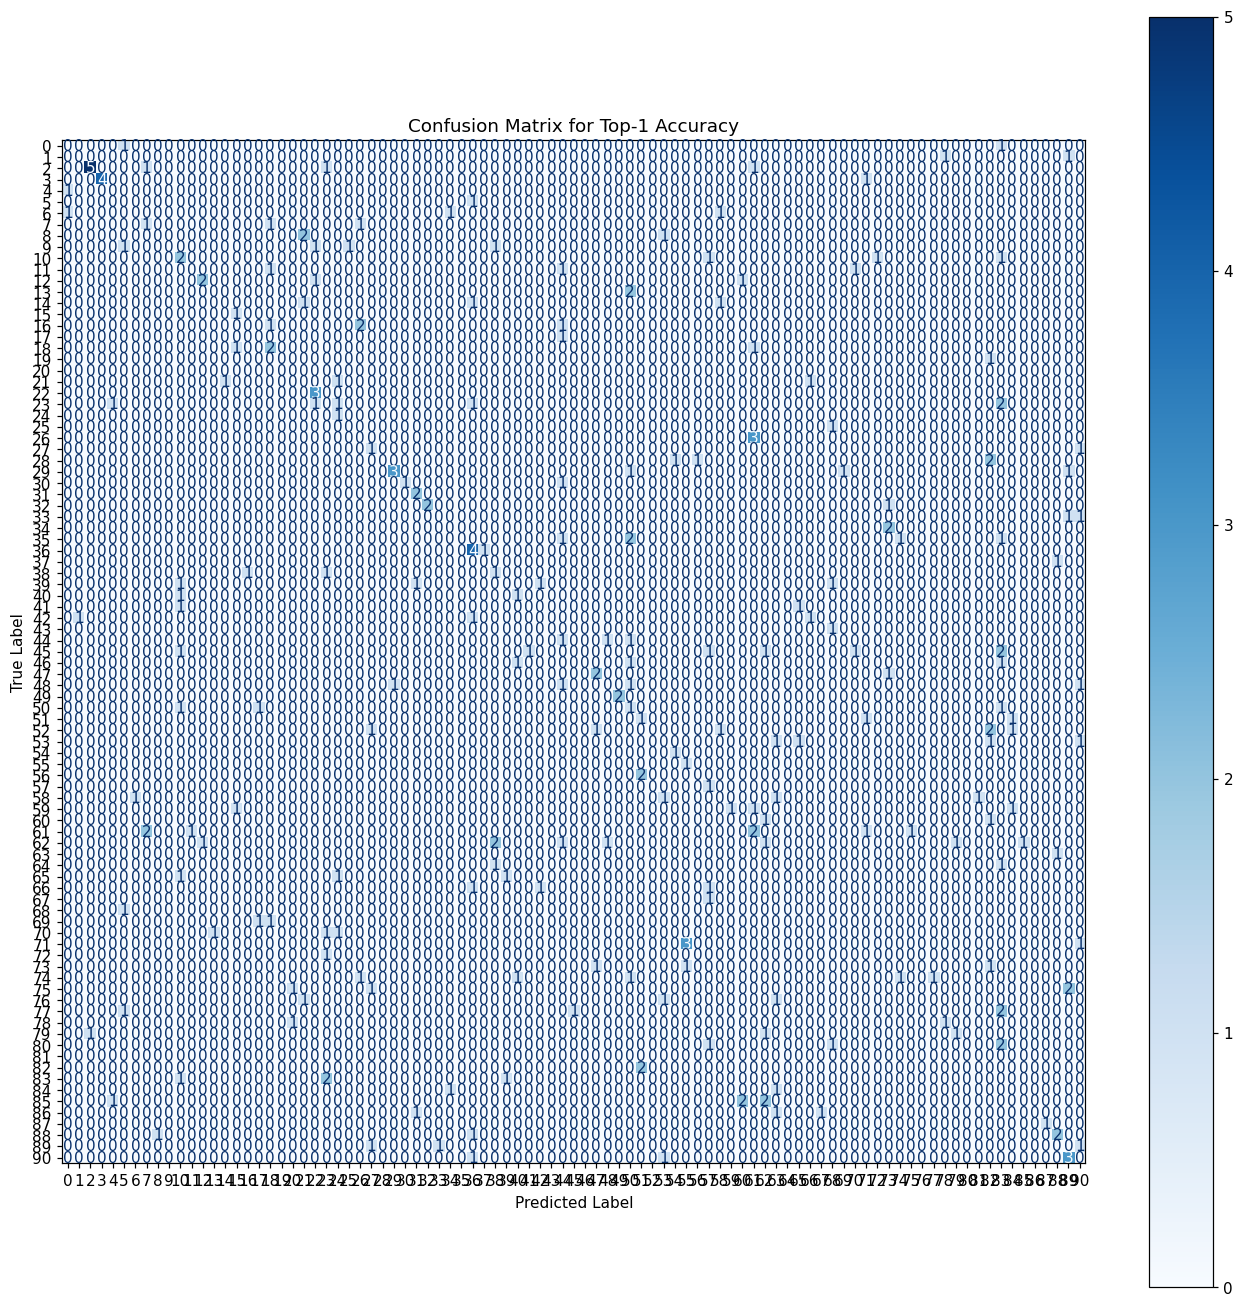

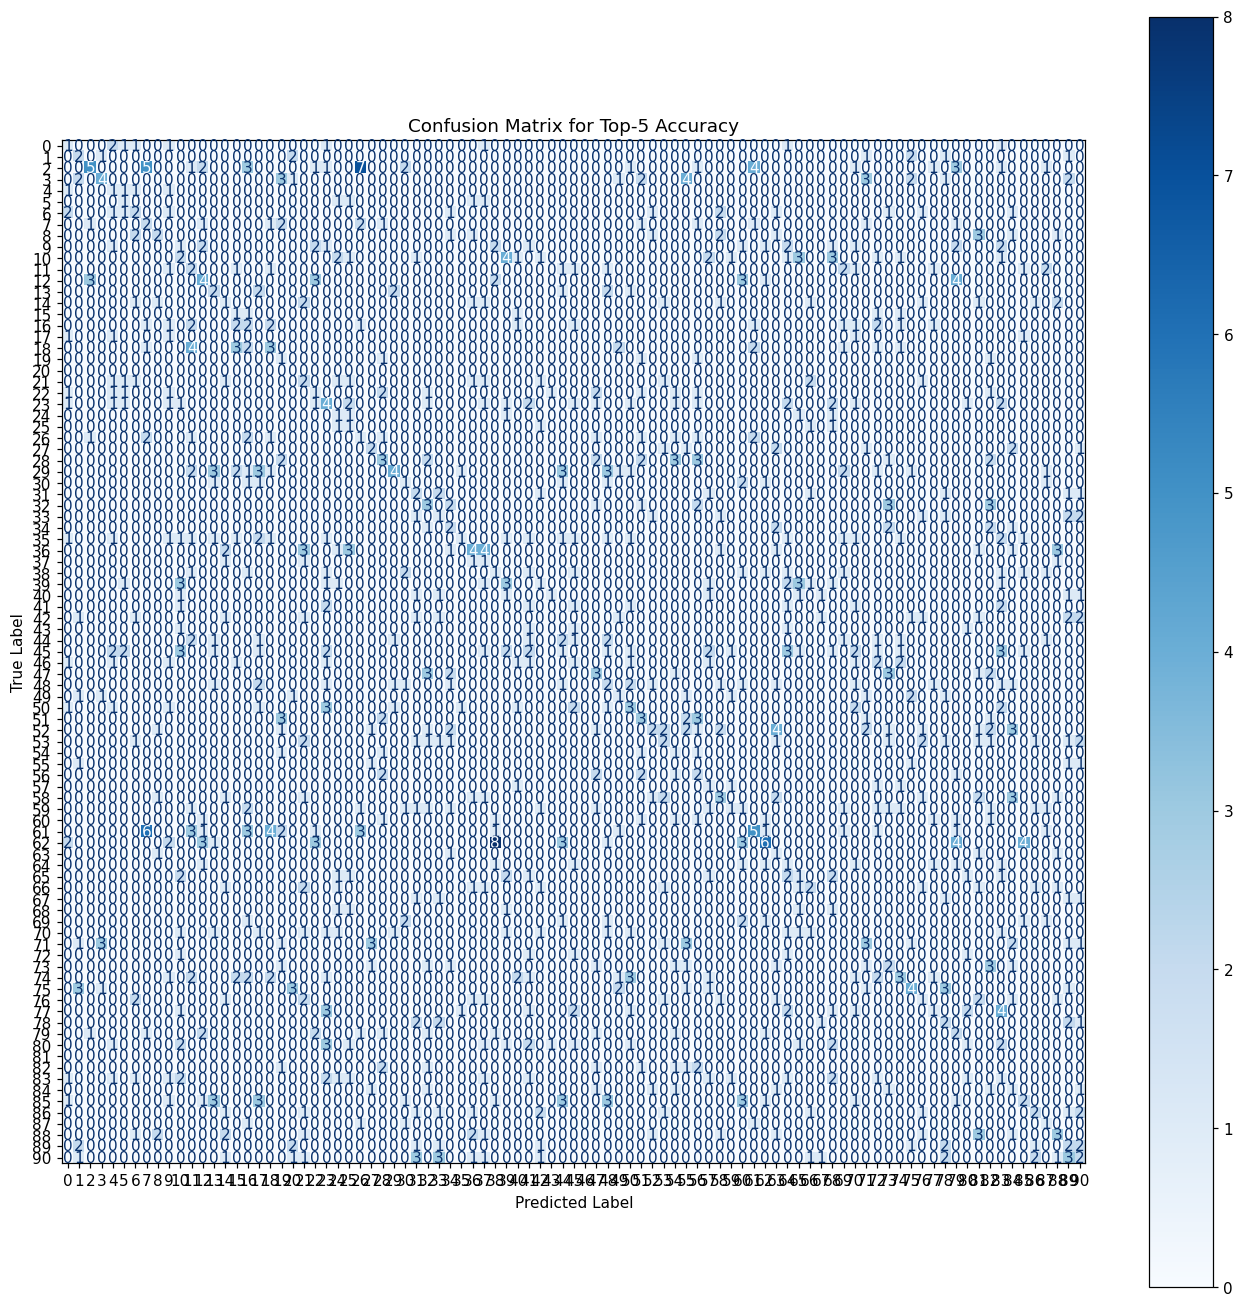

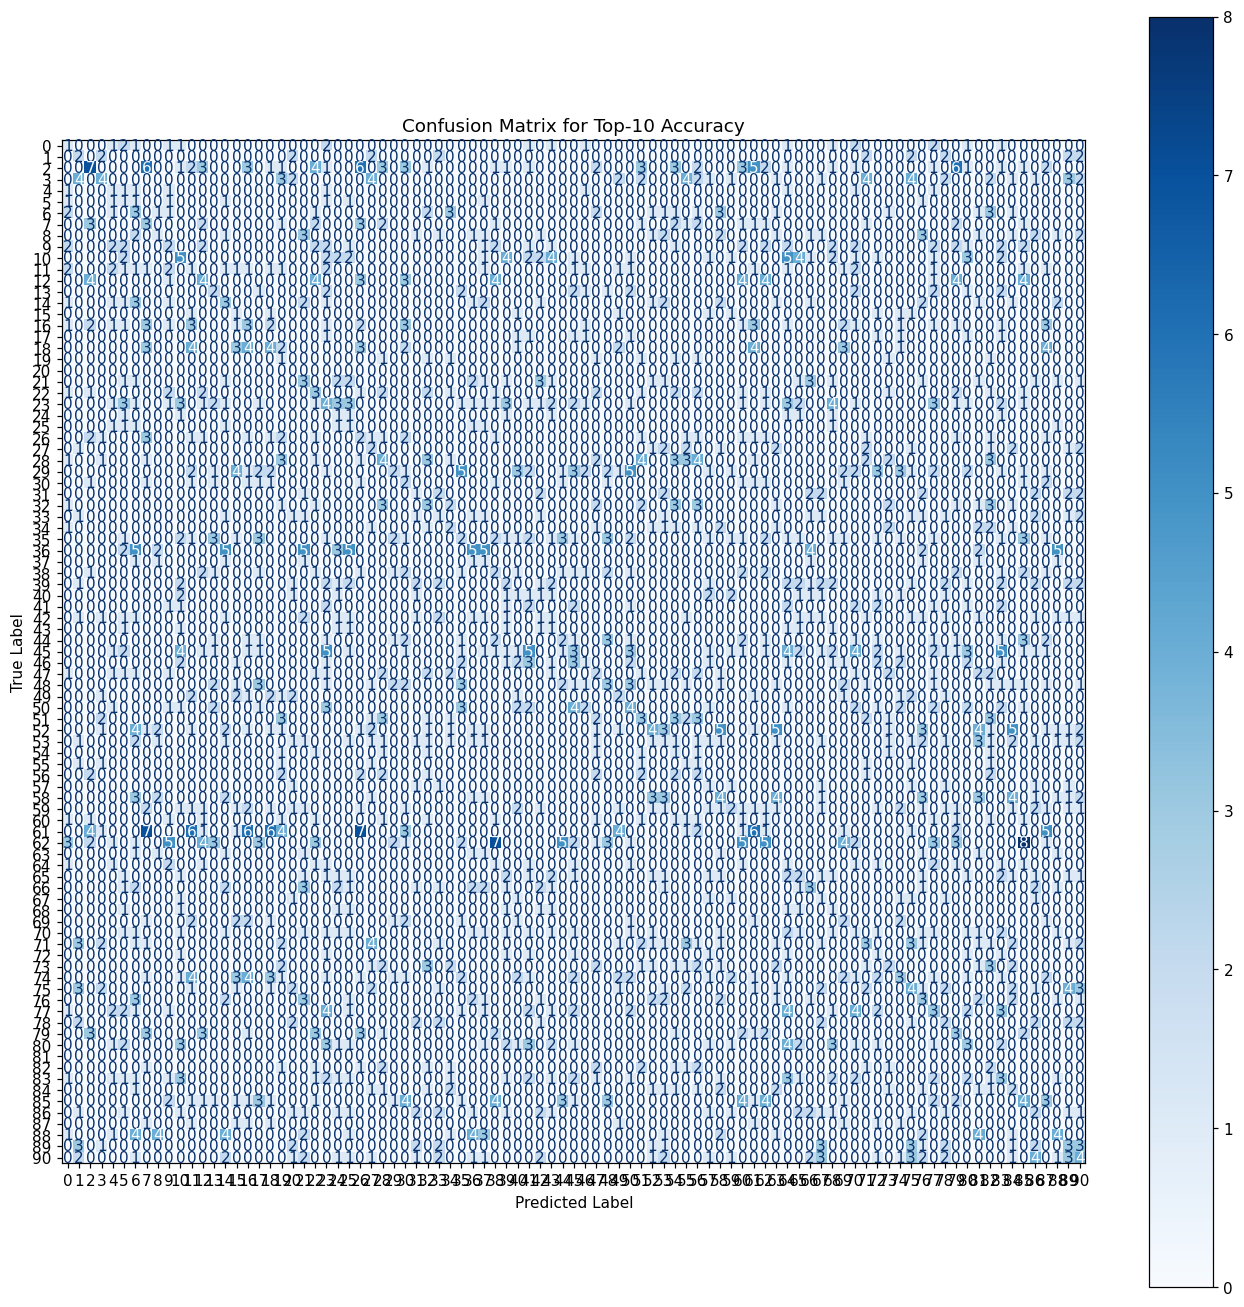

In [ ]:
# Confusion matrices:
import torch
import numpy as np
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader


# Initialize the model
model = LitClassifier(.025)

# Recreate the DataLoaders object for fastai
dls = DataLoaders(train_dl, val_dl)

# Recreate the Learner
learn = Learner(dls, model, loss_func=torch.nn.CrossEntropyLoss())

# Load the trained model
learn.load('trained_model')

# Create the test dataset and DataLoader
image_data = ImageDataset(pickle_file=f"{data_path}df.pkl", image_dir=f"{data_path}drizz_images.zip/content/processed_images/")
train_size = int(0.80 * len(image_data))
val_size = int((len(image_data) - train_size) / 2)
test_size = len(image_data) - train_size - val_size
_, _, test_set = random_split(image_data, (train_size, val_size, test_size))
test_dl = DataLoader(test_set, batch_size=model.batch_size)

def generate_top_k_confusion_matrix(k):
    confusion_matrix = np.zeros((91, 91), dtype=int)  # 91 unique classes

    with torch.no_grad():
        for batch in test_dl:
            images, tabular, labels = batch
            outputs = learn.model(images, tabular)
            top_k_preds = torch.topk(outputs, k=k, dim=1)[1]

            for label, preds in zip(labels, top_k_preds):
                for pred in preds:
                    confusion_matrix[label][pred] += 1

    fig, ax = plt.subplots(figsize=(15, 15), dpi=110)  # Adjust figure size if necessary
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    disp.plot(cmap=plt.cm.Blues, ax=ax)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Top-{k} Accuracy')
    plt.show()

# Generate confusion matrices for different top K accuracies
generate_top_k_confusion_matrix(1)  # Standard confusion matrix
generate_top_k_confusion_matrix(5)  # Top-5 accuracy
generate_top_k_confusion_matrix(10) # Top-10 accuracy


#Literature Comparison and Conclusion
Comparing our results to those found in the academic literature for our dataset, we see that our model falls a bit short. However, many of these academic papers have far more resources and more complex models than what we used for our process. For example, one academic paper found accuracies of 97% in their models based on DenseNet201 and ResNet50, which contain 201 and 50 convolutional layers respectively ([source](https://link.springer.com/article/10.1007/s00500-021-06640-1)). This is a model far more elaborate than ours, and the others come from departments of computer science at universities in India. By comparison, we made our model in the span of a couple of weeks using Google Colab after taking an introductory course. A more apt comparison comes from a student who made a similar model to us as a course final project at Stanford ([source](http://cs230.stanford.edu/projects_winter_2021/reports/70762359.pdf)). They, too, created the model inside of Google Colab and faced RAM issues, similar to us. They achieved an accuracy of 67% on their validation set, however they simply used a CNN to classify bird species based on spectrograms, without the addition of numerical data like we used.  It is noteworthy that none of that academic literature with our dataset used a hybrid input model as we did. All of the academic literature uses a single-input approach, a more established and refined method, and we expect this to be part of the reason for the disparity between their accuracy and ours.

We see the model that we created mainly as a proof of concept. Our primary goal was to combine two distinct types of data into a single model and use them to make a bird species prediction. We succeeded in doing so, and we made substantial improvements in accuracy from the start. With more time, resources, and experience, we expect that we could probably improve our model to produce a very accurate result that would outperform other models based on image-inputs alone. What we have successfully done is we have demonstrated that a hybrid-input deep learning model is possible, and it likely has great potential.

